In [ ]:
#load package
library(data.table)
library(qs)
library(GenomicRanges)
library(GenomicFeatures)
library(rtracklayer)
library(dplyr)
library(ggbio)
library(reshape2)
library(ggsci)
library(viridis)
library(ggpubr)
library(circlize)
library(ggh4x)
library(ggtranscript)
library(khroma)
library(randomcoloR)
library(bambu)
library(ggdensity)
library(Seurat)
library(scCustomize)
library(ComplexUpset)
library(ComplexHeatmap)

qs 0.25.5

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:data.table’:

    first, second


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: I

In [ ]:
#load all bambu annotation for T44(M1-1)
files = list.files("/cluster/home/hongyanhong/projects/MAS-seq/combined_fulllenmatrix/",full.names = T)
fgtf = NULL
for(i in files[1:4]){
    fi = read.table(i)
    colnames(fi) = c("transid","fulllength")
    fgtf = rbind(fgtf,fi)
}
head(fgtf)

,transid,fulllength
,<chr>,<dbl>
BambuTx1,BambuTx1,129.00000
BambuTx2,BambuTx2,5.00001
BambuTx3,BambuTx3,19.00000
BambuTx4,BambuTx4,629.00000
BambuTx5,BambuTx5,9.00000
BambuTx6,BambuTx6,38.00000


## Filter gtf make annotation

In [ ]:
bambuiso = qread("bambu.qs", nthreads = 100)
bambuiso
bambuiso = bambuiso[rowSums(assays(bambuiso)$CPM)>0]
dir.create("processed_data/bambu_longread_count/bambu_ref")
writeToGTF(rowRanges(bambuiso),file = "processed_data/bambu_longread_count/bambu_ref/bambu_extended_annotations.gtf")
#filter bambu
traninfo = mcols(bambuiso)
traninfo
readtrans = rowRanges(bambuiso)
readtrans
traninfofil = traninfo[(!is.na(traninfo$NDR) & traninfo$NDR<0.80) | is.na(traninfo$NDR) | traninfo$txClassDescription == "annotation",]
qsave(list("transinfo" = traninfo, "transinfo_hub" = traninfofil),"processed_data/bambu_longread_count/bambu_ref/bambu_extended_annotations_transinfo.qs")

In [ ]:
gtfinfo = qread("ref/bambu_extended_annotations_transinfo.qs")
gtfinfo = gtfinfo$transinfo

gtfinfokn.tr = gtfinfo[gtfinfo$novelTranscript != TRUE,]
gtfinfonv.tr = gtfinfo[gtfinfo$novelTranscript == TRUE,]
gtfinfokn.tr[is.na(gtfinfokn.tr$readCount),]$readCount = 0
gtfinfonv.trf = gtfinfonv.tr[!is.na(gtfinfonv.tr$NDR) & gtfinfonv.tr$NDR < 0.80,]
gtfinfofil = rbind(gtfinfonv.trf,gtfinfokn.tr)

gtfinfokn = gtfinfofil[gtfinfofil$novelGene  != TRUE,]
gtfinfonv = gtfinfofil[gtfinfofil$novelGene  == TRUE,]

gtfinfonv.st = as.data.frame(gtfinfonv) %>% group_by(GENEID) %>% summarise(fullLengthCounts = sum(fullLengthCounts))
gtfinfonv.st = gtfinfonv.st[gtfinfonv.st$fullLengthCounts > 30,]
gtfinfonv = gtfinfonv[gtfinfonv$GENEID %in% gtfinfonv.st$GENEID,]
gtfinfo = rbind(as.data.frame(gtfinfonv),as.data.frame(gtfinfokn))

#gtf new transname
gtfdf = as.data.frame(gtff)
gtfdfan = gtfdf[gtfdf$type == "transcript",]
gtfdfan = gtfdfan[order(gtfdfan$gene_id,gtfdfan$start,gtfdfan$end,gtfdfan$transcript_id),]
gtfdfan$trantype = "known"
gtfdfan[substr(gtfdfan$transcript_id,1,5) == "Bambu",]$trantype = "novel"
gtfdfan$transnew = gtfdfan$transcript_id
gtfdfan.known = gtfdfan[gtfdfan$trantype == "known",]
gtfdfan.novel = gtfdfan[gtfdfan$trantype == "novel",]
gtfdfan.novel = gtfdfan.novel %>% group_by(gene_id) %>% mutate(transnew = paste0(gene_id,"-WeiLab-",1:n()))
gtfdfan.novel = gtfdfan.novel[gtfdfan.novel$width > 200 & gtfdfan.novel$exon > 1,]
gtfdfan = rbind(gtfdfan.novel,gtfdfan.known)
write.csv(gtfdfan,file = "ref/gtf_new_transcript_name_map_04_30.csv",row.names = F,quote = F)
gtff = gtff[gtff$gene_id %in% gtfdfan$gene_id,]
gtff$transcript_name = gtfdfan[match(gtff$transcript_id,gtfdfan$transcript_id),]$transnew
gtff$transcript_id = gtff$transcript_name

In [30]:
#make a full annotation and rename matrix
gtfdfan = read.csv("ref/gtf_new_transcript_name_map_04_30.csv")
gtfdfan = unique(gtfdfan[,c("gene_id","transcript_id","trantype","transnew")])
nrow(gtfdfan)
gtfdfant = unique(fsraw[,c("gene_id","transcript_id")])
gtfdfant = gtfdfant[!is.na(gtfdfant$transcript_id),]
head(gtfdfant)
nrow(gtfdfant)
head(gtfdfan)
nrow(gtfdfant)
gtfdfant = merge(gtfdfant,gtfdfan,by = c("gene_id","transcript_id"),all = TRUE)
nrow(gtfdfant)
qsave(gtfdfant,file = "ref/bambu_trans_total_oldname_newname_25_10_09.qs")

,gene_id,transcript_id,trantype,transnew
,<chr>,<chr>,<chr>,<chr>
1,AAAS,BambuTx122957,novel,AAAS-WeiLab-1
2,AAAS,BambuTx22391,novel,AAAS-WeiLab-2
3,AADAT,BambuTx11228,novel,AADAT-WeiLab-1
4,AAED1,BambuTx30778,novel,AAED1-WeiLab-1
5,AAED1,BambuTx30780,novel,AAED1-WeiLab-2
6,AAMDC,BambuTx28589,novel,AAMDC-WeiLab-1


[1] 127050

[1] 135984

In [ ]:
fgtf$fulllength = as.integer(fgtf$fulllength)
fgtf.st = fgtf %>% group_by(transid) %>% summarise(fulllength = sum(fulllength))
nrow(fgtf.st)
head(fgtf.st)
fgtf.st = fgtf.st[((substr(fgtf.st$transid,1,5) == "Bambu") & (fgtf.st$fulllength > 30)) |
                  ((substr(fgtf.st$transid,1,5) != "Bambu") & (fgtf.st$fulllength > 0)),]

nrow(fgtf.st)
nrow(fgtf.st[substr(fgtf.st$transid,1,5) != "Bambu",])
nrow(fgtf.st[substr(fgtf.st$transid,1,5) == "Bambu",])
gtfdfant.fil = merge(gtfdfant,fgtf.st,by.x = "transcript_id",by.y = "transid")
nrow(gtfdfant.fil)
#gtfdfant.fil = gtfdfant.fil[gtfdfant.fil$gene_id %in% gtfo.st.nv$gene_id,]
# gtfdfant.fil = gtfdfant.fil[gtfdfant.fil$transcript_id %in% gtfinfofil$TXNAME,]
# nrow(gtfdfant.fil)
#length(unique(gtfo.st.nv[gtfo.st.nv$gene_id %in% gtfdfant.fil$gene_id,]$gene_id))

[1] 401839

transid,fulllength
<chr>,<int>
BambuTx1,599
BambuTx10,203
BambuTx100,5
BambuTx1000,413
BambuTx10000,45
BambuTx100000,43


[1] 71455

[1] 31671

[1] 39784

[1] 49606

In [156]:
gtfdfant.kn = gtfdfant.fil[substr(gtfdfant.fil$gene_id,1,5) != "Bambu",]
length(unique(gtfdfant.kn[substr(gtfdfant.kn$transcript_id,1,5) == "Bambu",]$transcript_id))
length(unique(gtfdfant.kn[substr(gtfdfant.kn$transcript_id,1,5) != "Bambu",]$transcript_id))
summary(gtfdfant.kn$fulllength)

[1] 6459

[1] 31671

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      1       7      60    5683     433 3852656 

In [168]:
head(gtfdfant.kn)
gtfdfant.kn$transnew2 = gsub(gtfdfant.kn$transnew,pattern = "WeiLab",replacement = "FS")
write.csv(gtfdfant.kn,file = "ref/gtf_filter_final_with_newname_25_10_09.csv",row.names = F,quote = F)

,transcript_id,gene_id,trantype,transnew,fulllength
,<chr>,<chr>,<chr>,<chr>,<int>
1,BambuTx1,PGBD2,novel,PGBD2-WeiLab-1,599
2,BambuTx10,ZNF669,novel,ZNF669-WeiLab-1,203
3,BambuTx1000,USP21,novel,USP21-WeiLab-2,413
6,BambuTx100007,LOC102142787,novel,LOC102142787-WeiLab-1,105
11,BambuTx100045,EXOC3L4,novel,EXOC3L4-WeiLab-1,72
12,BambuTx100047,EXOC3L4,novel,EXOC3L4-WeiLab-2,37


## Isoform plot

In [5]:
gtfdfant.kn = read.csv("ref/gtf_filter_final_with_newname_25_10_09.csv")
head(gtfdfant.kn)
gtfinfo = qread("ref/bambu_extended_annotations_transinfo.qs")
gtfinfo = gtfinfo$transinfo
head(gtfinfo)

,transcript_id,gene_id,trantype,transnew,fulllength,transnew2
,<chr>,<chr>,<chr>,<chr>,<int>,<chr>
1,BambuTx1,PGBD2,novel,PGBD2-WeiLab-1,599,PGBD2-FS-1
2,BambuTx10,ZNF669,novel,ZNF669-WeiLab-1,203,ZNF669-FS-1
3,BambuTx1000,USP21,novel,USP21-WeiLab-2,413,USP21-FS-2
4,BambuTx100007,LOC102142787,novel,LOC102142787-WeiLab-1,105,LOC102142787-FS-1
5,BambuTx100045,EXOC3L4,novel,EXOC3L4-WeiLab-1,72,EXOC3L4-FS-1
6,BambuTx100047,EXOC3L4,novel,EXOC3L4-WeiLab-2,37,EXOC3L4-FS-2


DataFrame with 6 rows and 12 columns
              TXNAME       GENEID       NDR novelGene novelTranscript
         <character>  <character> <numeric> <logical>       <logical>
BambuTx1    BambuTx1        PGBD2  0.548446     FALSE            TRUE
BambuTx2    BambuTx2       ZNF692  0.901575     FALSE            TRUE
BambuTx3    BambuTx3       ZNF692  0.832564     FALSE            TRUE
BambuTx4    BambuTx4 LOC107130781  0.258162     FALSE            TRUE
BambuTx5    BambuTx5      SH3BP5L  0.921423     FALSE            TRUE
BambuTx6    BambuTx6        NLRP3  0.725336     FALSE            TRUE
             txClassDescription readCount relReadCount relSubsetCount      txid
                    <character> <integer>    <numeric>      <numeric> <integer>
BambuTx1 newLastJunction:newL..       127   0.41368078       1.000000         1
BambuTx2              newWithin         7   0.00328022       0.538462         2
BambuTx3            newJunction        19   0.00890347       0.791667         3
Bam

In [6]:
nrow(gtfinfo)
nrow(gtfdfant.kn)
gtfinfo = as.data.frame(gtfinfo)
gtfinfo = gtfinfo[gtfinfo$TXNAME %in% gtfdfant.kn$transcript_id,]
nrow(gtfinfo)

[1] 401839

[1] 38130

[1] 38130


                                                               allNew 
                                                                 3023 
                                                           annotation 
                                                                31671 
                                                     newFirstJunction 
                                                                  282 
                                        newFirstJunction:newFirstExon 
                                                                  343 
                                         newFirstJunction:newJunction 
                                                                  357 
                            newFirstJunction:newJunction:newFirstExon 
                                                                  455 
                                                          newJunction 
                                                                  560 
     

file saved to result/figure1/bambu_novel_isoform_stat_bar_25_10_13.pdf



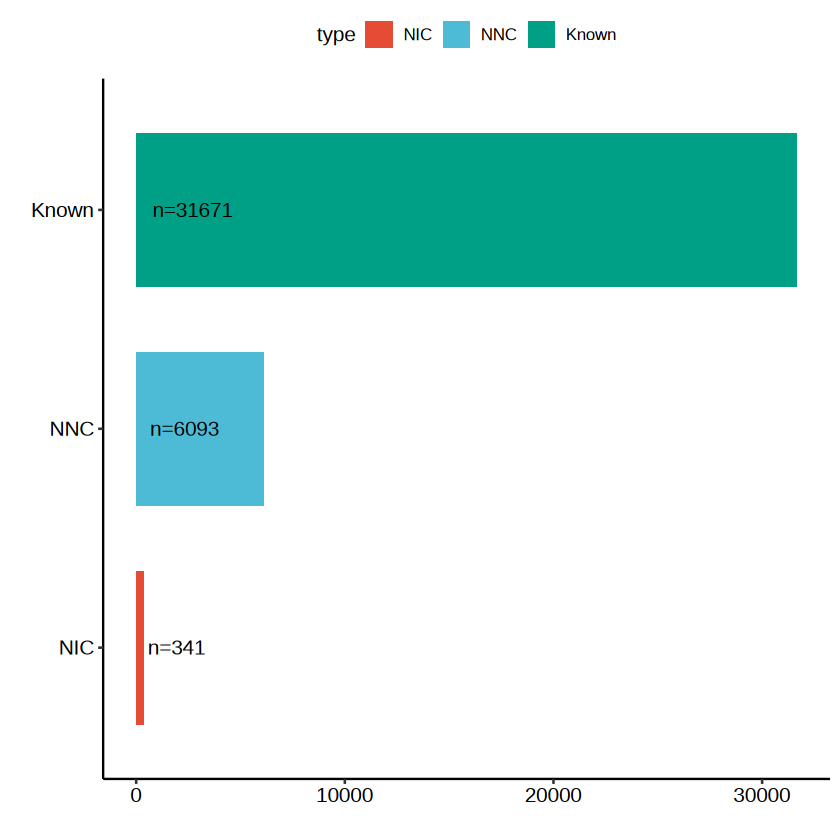

In [7]:
#isoform stat
trannovel = gtfinfo[gtfinfo$novelGene == F,]
#trannovel = trannovel[trannovel$TXNAME %in% fsrawdp$transcript_name,]
table(trannovel$txClassDescription)
trannovel$type = "NNC"
trannovel[trannovel$txClassDescription %in% c("newWithin","newLastExon","newFirstExon","newFirstExon:newLastExon"),"type"] = "NIC"
trannovel[trannovel$txClassDescription == "annotation","type"] = "Known"
#trannovel[trannovel$txClassDescription == "allNew","type"] = "NNC_all"
library(ggplot2)
library(ggpubr)
trannovelst = trannovel %>% group_by(type) %>% summarise(number = n())
trannovelst = trannovelst[order(trannovelst$number,decreasing = F),]
trannovelst$type = factor(trannovelst$type,levels = trannovelst$type)
p1 = ggplot(trannovelst,aes(y = type,x = number,fill = type)) + 
    geom_bar(stat = "identity",width = 0.7) + 
    geom_text(aes(y = type,x = 0,label = paste0("n=",number)),
              hjust = -0.2) +
    xlab("") + ylab("") +
    scale_fill_npg() +
    theme_pubr() 
p1
ggexport(p1,filename = "result/figure1/bambu_novel_isoform_stat_bar_25_10_13.pdf",
           width = 4,height = 4)

In [ ]:
 #isoform number stat
genest = fsraw.cor %>% group_by(gene_id) %>% summarise(readnum = length(unique(readid)))
genest = genest[order(genest$readnum,decreasing = T),]
  #total basic number stat
isoformst = fsraw.cor[fsraw.cor$gene_id %in% genest[genest$readnum > 100,
                                                     ]$gene_id,] %>% 
    group_by(gene_id) %>% 
    summarise(trannum = length(unique(transcript_id)))
  
  mtransnum = mean(isoformst$trannum)
isoformst1 = as.data.frame(table(isoformst$trannum))

isoformst1$prop = isoformst1$Freq/sum(isoformst1$Freq)
isoformst1f = isoformst1[as.numeric(isoformst1$Var1) <= 15,]
isoformst1f2 = isoformst1[as.numeric(isoformst1$Var1) > 15,]
isoformst1 = rbind(isoformst1f,data.frame("Var1" = ">15",
                                            "Freq" = sum(isoformst1f2$Freq),
                                            "prop" = sum(isoformst1f2$prop)))
isoformst1$prop = round(isoformst1$prop,3)*100
  
  pis1 = ggplot(isoformst1,aes(x = Var1,y = Freq,fill = Var1)) + 
    geom_bar(stat = "identity") +
    scale_y_continuous(limits = c(0,6500)) +
    geom_text(aes(label = prop),hjust = 0,angle = 90) +
    ggtitle(paste0("Mean isoform number = ", round(mtransnum,3))) +
    scale_fill_viridis(discrete = T,option = "A")+ xlab("") + 
    ylab("Gene number") +
    theme_pubr() +theme(legend.position = "none")
  pis1
  ggexport(pis1,filename = "result/figure1/bam_iso_basic_stat1_isoform_number_gene_100read_25_10_10.pdf",
           width = 5,height = 4)